In [9]:
import time
import re
import json
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
def graph_heatmap(resultados, tops):
    import matplotlib.pyplot as plt
    import seaborn as sns
    # Crear matriz de coincidencias de href
    coincidencias = {}
    for pais in resultados:
        coincidencias[pais["country"]] = {}
        for pais2 in resultados:
            coincidencias[pais["country"]][pais2["country"]] = 0

    for i in range(len(tops)-1):
        for pais in resultados:
            for pais2 in resultados:
                for result in pais["search_results"]["results"][tops[i]:tops[i+1]]:
                    for result2 in pais2["search_results"]["results"][tops[i]:tops[i+1]]:
                        if result["href"] == result2["href"]:
                            coincidencias[pais["country"]][pais2["country"]] += 1

        # Crear matriz de coincidencias
        matriz = []
        for pais in coincidencias:
            matriz.append([coincidencias[pais][pais2] for pais2 in coincidencias])

        # Crear heatmap
        plt.figure(figsize=(10, 10))
        sns.heatmap(matriz, annot=True, fmt="d", xticklabels=coincidencias.keys(), yticklabels=coincidencias.keys(), vmin=0, vmax=tops[i+1], cmap="YlGnBu_r")
        plt.title("Matriz de coincidencias de resultados de búsqueda de 'Corrupción' (Top {})".format(tops[i+1]))

        # Guardar heatmap
        # plt.savefig("Coincidencias/heatmap_violencia.png")

        plt.show()

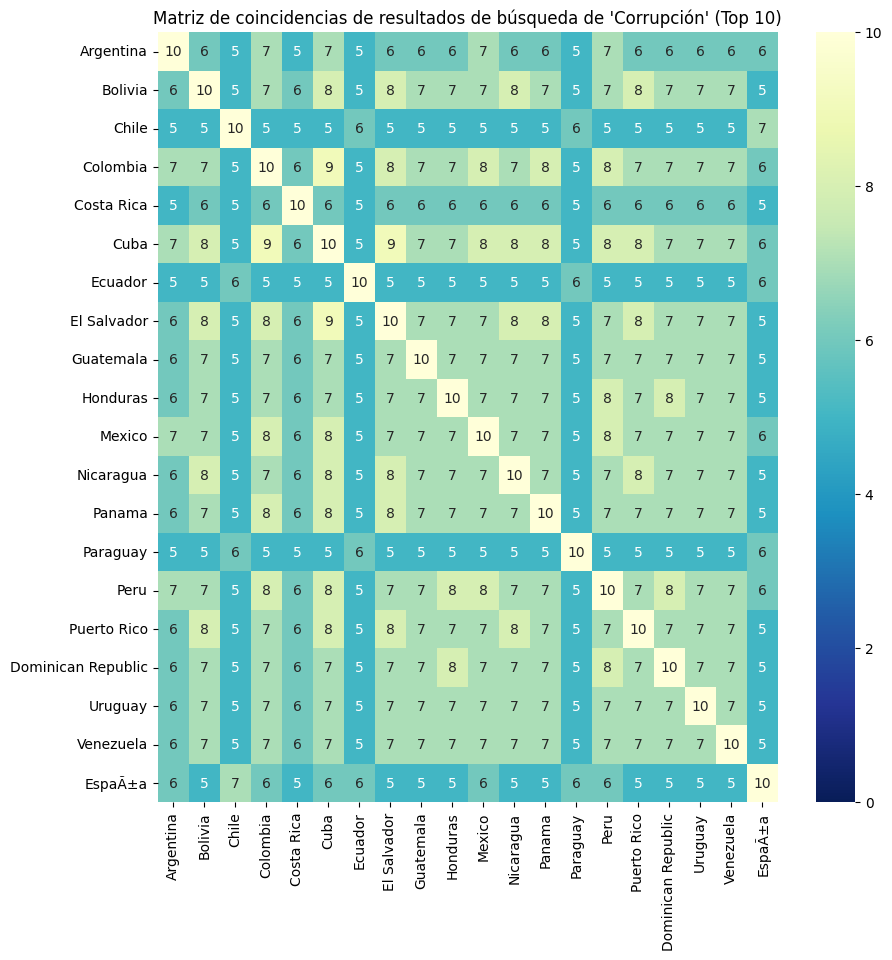

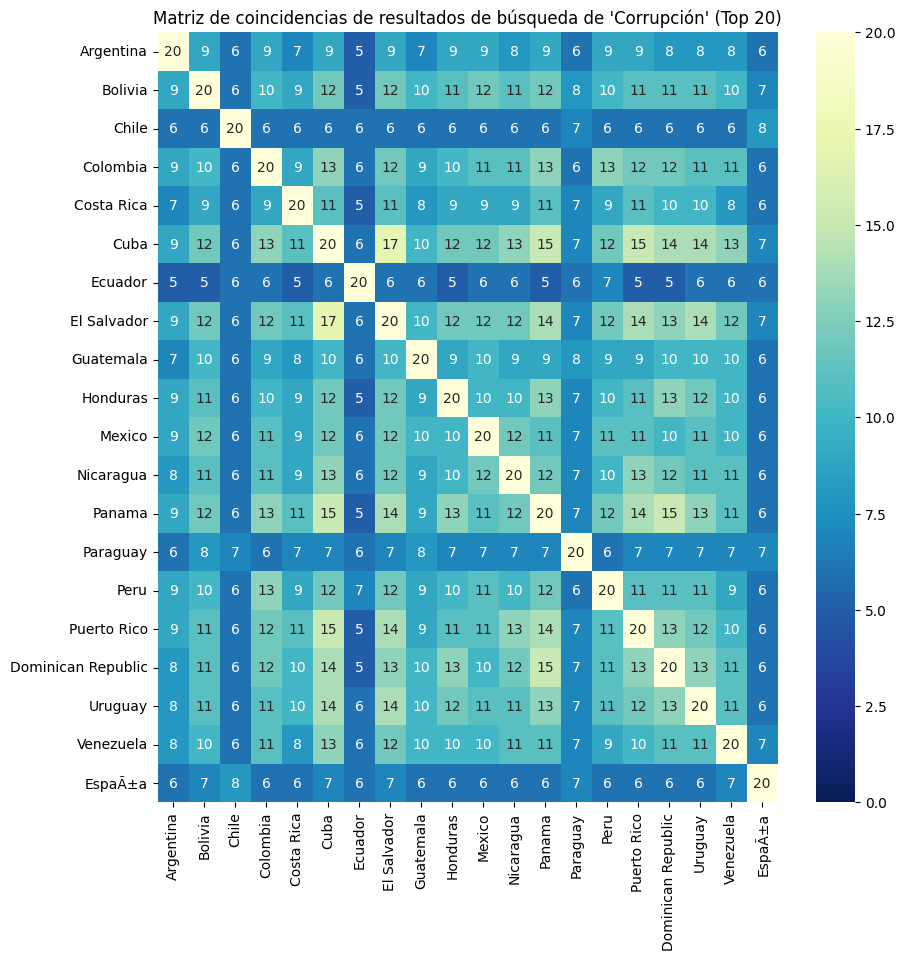

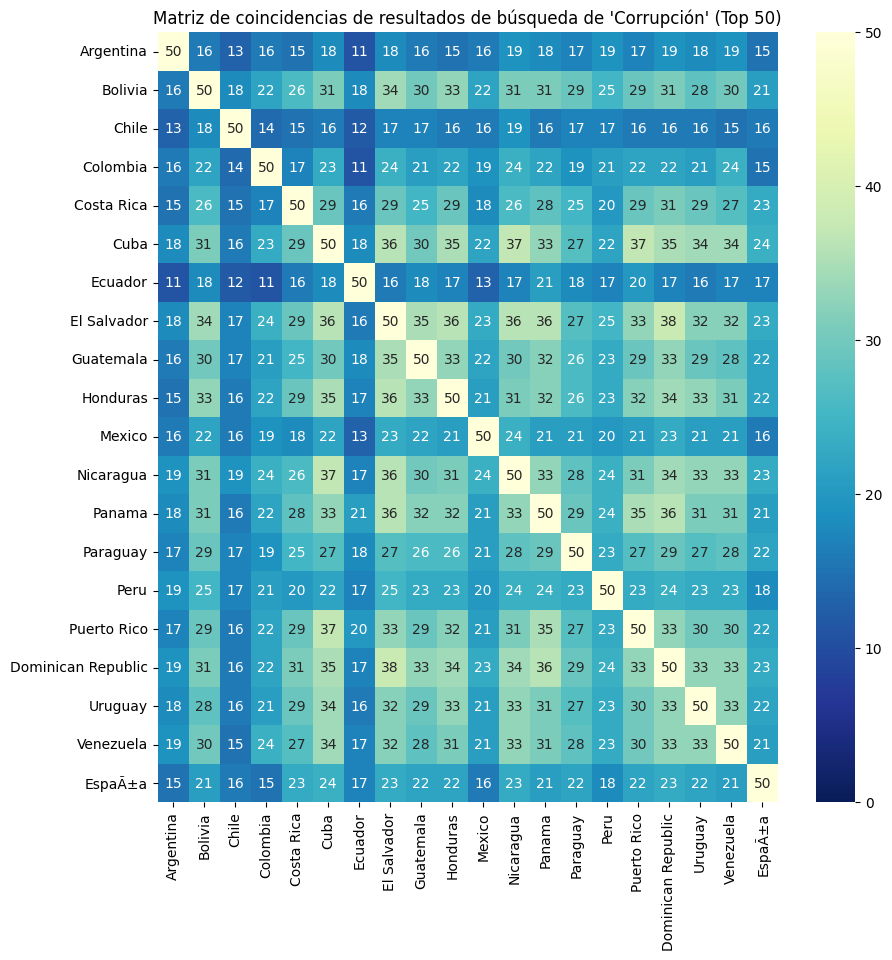

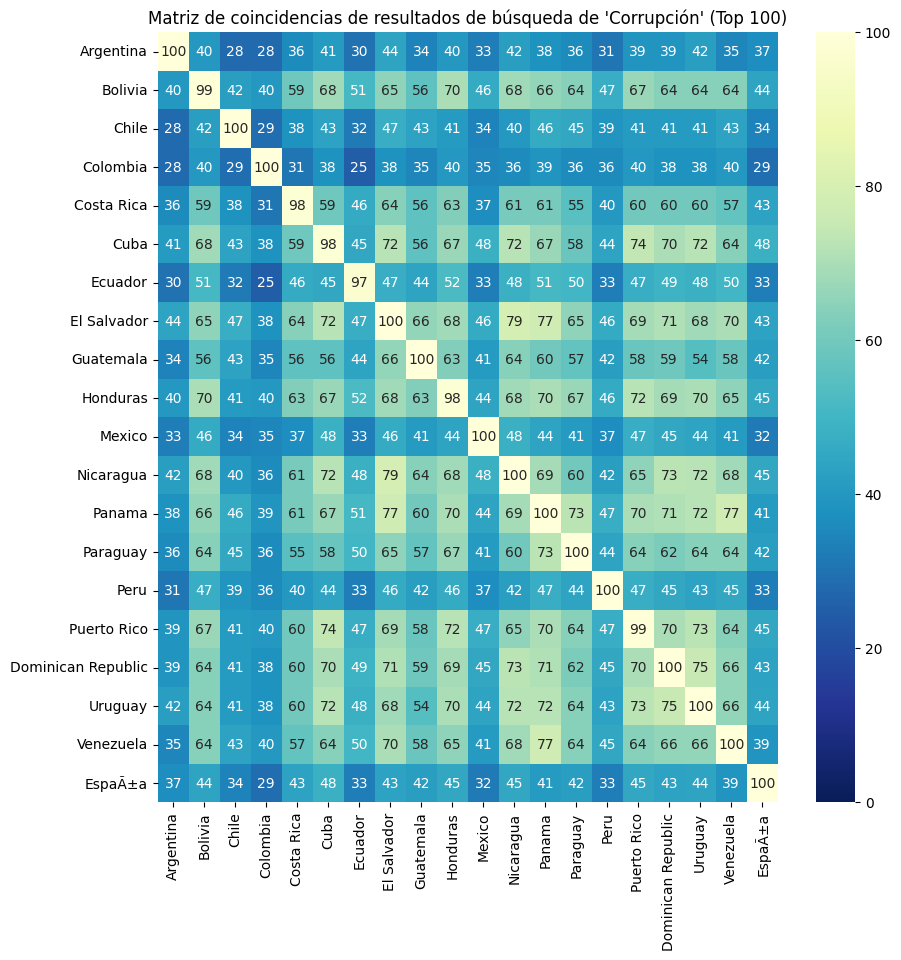

In [11]:
# Leer el archivo JSON guardado
Nombre_Archivo = f"./resultados/resultados_corrupcion.json"

with open(Nombre_Archivo, "r") as file:
    resultados = json.load(file)

graph_heatmap(resultados, [0, 10])
graph_heatmap(resultados, [0, 20])
graph_heatmap(resultados, [0, 50])
graph_heatmap(resultados, [0, 100])

# Correlaciones

In [12]:
# Leer el archivo JSON guardado
Nombre_Archivo = f"./resultados/res_unicos_corrupcion.json"

with open(Nombre_Archivo, "r") as file:
    all_hrefs = json.load(file)

In [13]:
import pandas as pd
from math import isnan
from scipy.stats import kendalltau, spearmanr

def build_aligned_ranks(rank_list, universe, top, absent_policy="max_plus_one"):
    """
    rank_list: lista de dicts con clave 'href', en orden de ranking.
    universe: lista/iterable con todos los hrefs a alinear.
    top: entero, cuántos tomas de rank_list.
    absent_policy:
      - 'max_plus_one': rank = len(universe) + 1 a los ausentes
      - '1.5top': rank = int(1.5 * top) a los ausentes
    """
    pos = {item['href']: i+1 for i, item in enumerate(rank_list)}  # 1..len(list)
    if absent_policy == "max_plus_one":
        absent_rank = len(universe) + 1
    elif absent_policy == "1.5top":
        absent_rank = int(1.5 * top)
    else:
        absent_rank = len(universe) + 1
    return [pos.get(u, absent_rank) for u in universe]

def correlation_matrix(results, universe, top, method="spearman", absent_policy="max_plus_one"):
    """
    results: lista de dicts con llaves ["country"] y ["search_results"]["results"]
    method: "spearman" (rho) o "kendall" (tau-b)
    """
    countries = [c["country"] for c in results]
    aligned = {
        c["country"]: build_aligned_ranks(
            c["search_results"]["results"][:top], universe, top, absent_policy=absent_policy
        )
        for c in results
    }

    corr_data, pval_data = [], []
    for c1 in countries:
        row_corr, row_p = [], []
        x = aligned[c1]
        for c2 in countries:
            y = aligned[c2]
            if method == "spearman":
                r, p = spearmanr(x, y)
            elif method == "kendall":
                r, p = kendalltau(x, y)
            else:
                raise ValueError("method debe ser 'spearman' o 'kendall'")
            row_corr.append(0.0 if (r is None or isnan(r)) else float(r))
            row_p.append(1.0 if (p is None or isnan(p)) else float(p))
        corr_data.append(row_corr)
        pval_data.append(row_p)

    corr_df = pd.DataFrame(corr_data, index=countries, columns=countries)
    p_df    = pd.DataFrame(pval_data, index=countries, columns=countries)
    return corr_df, p_df, aligned


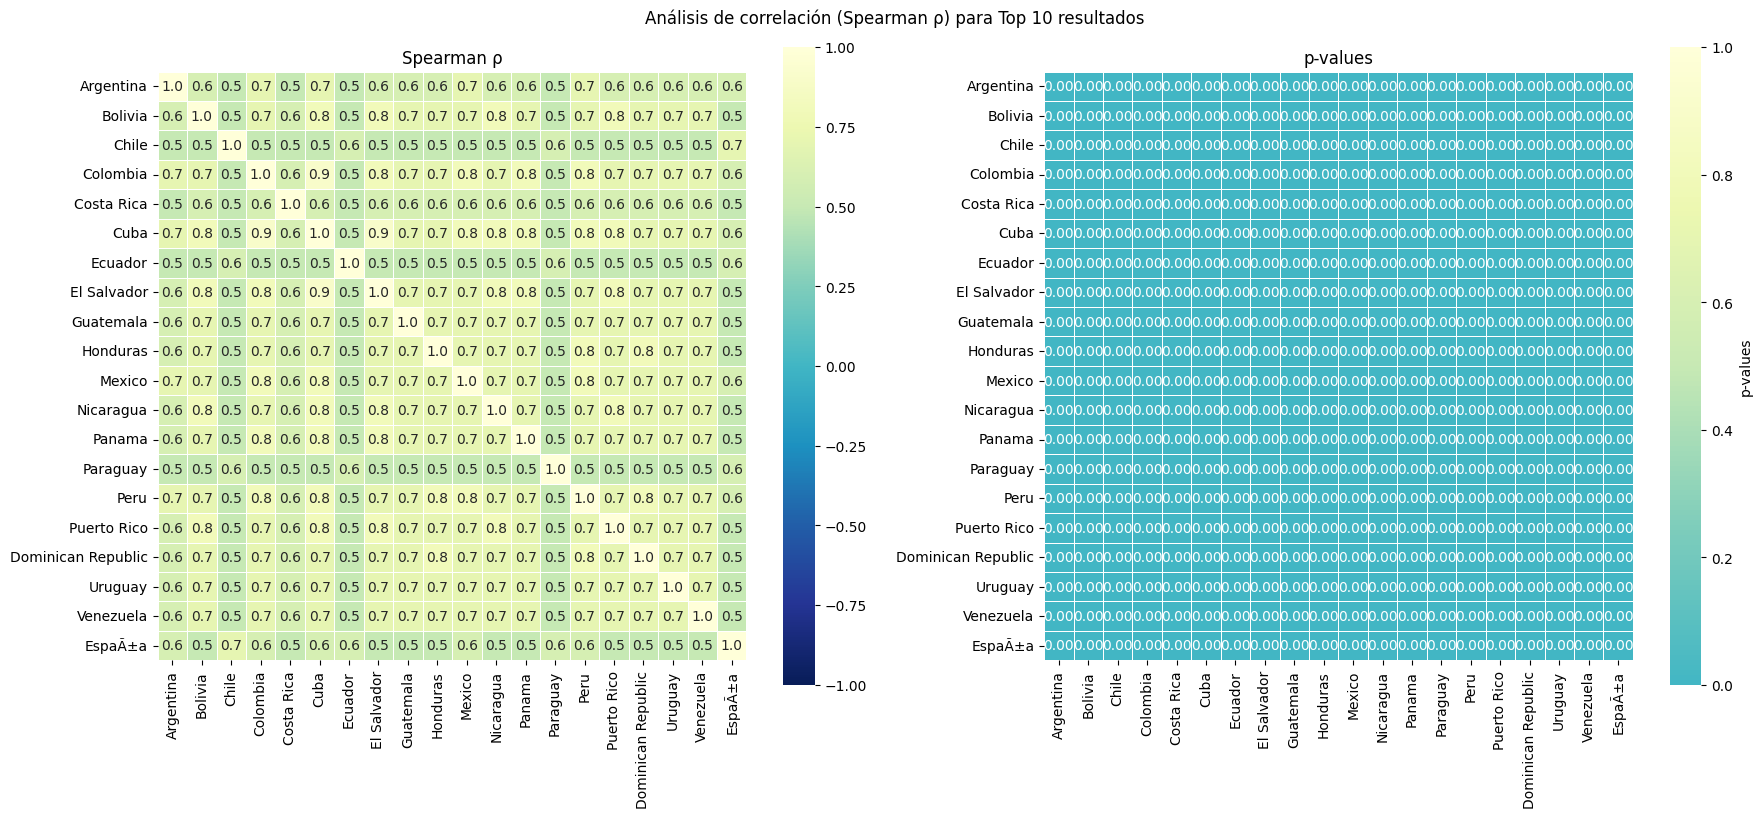

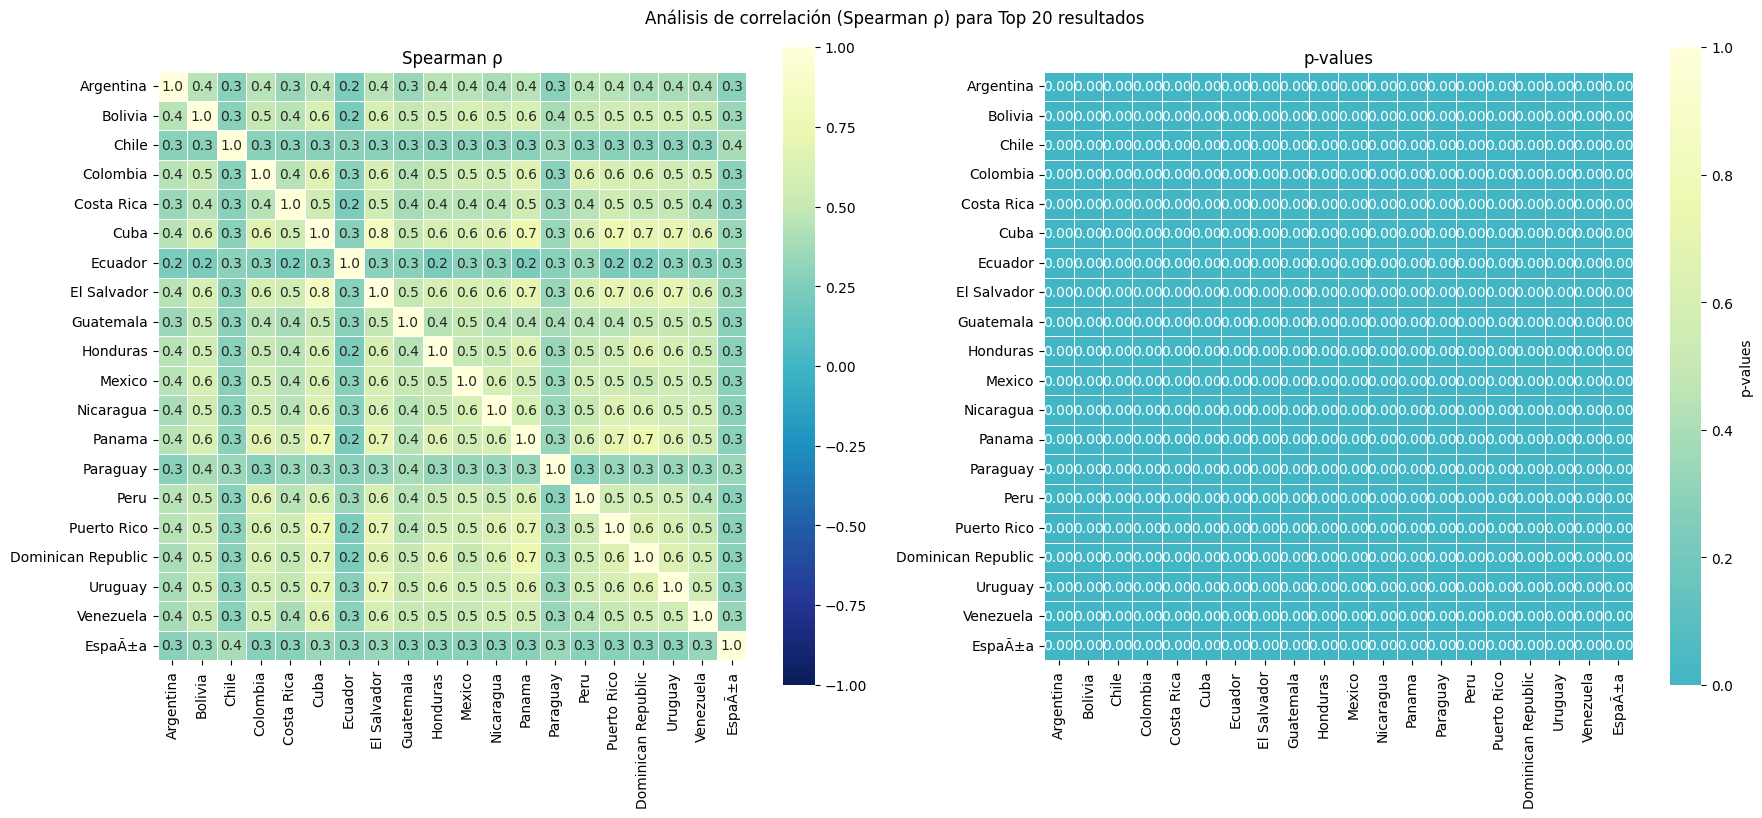

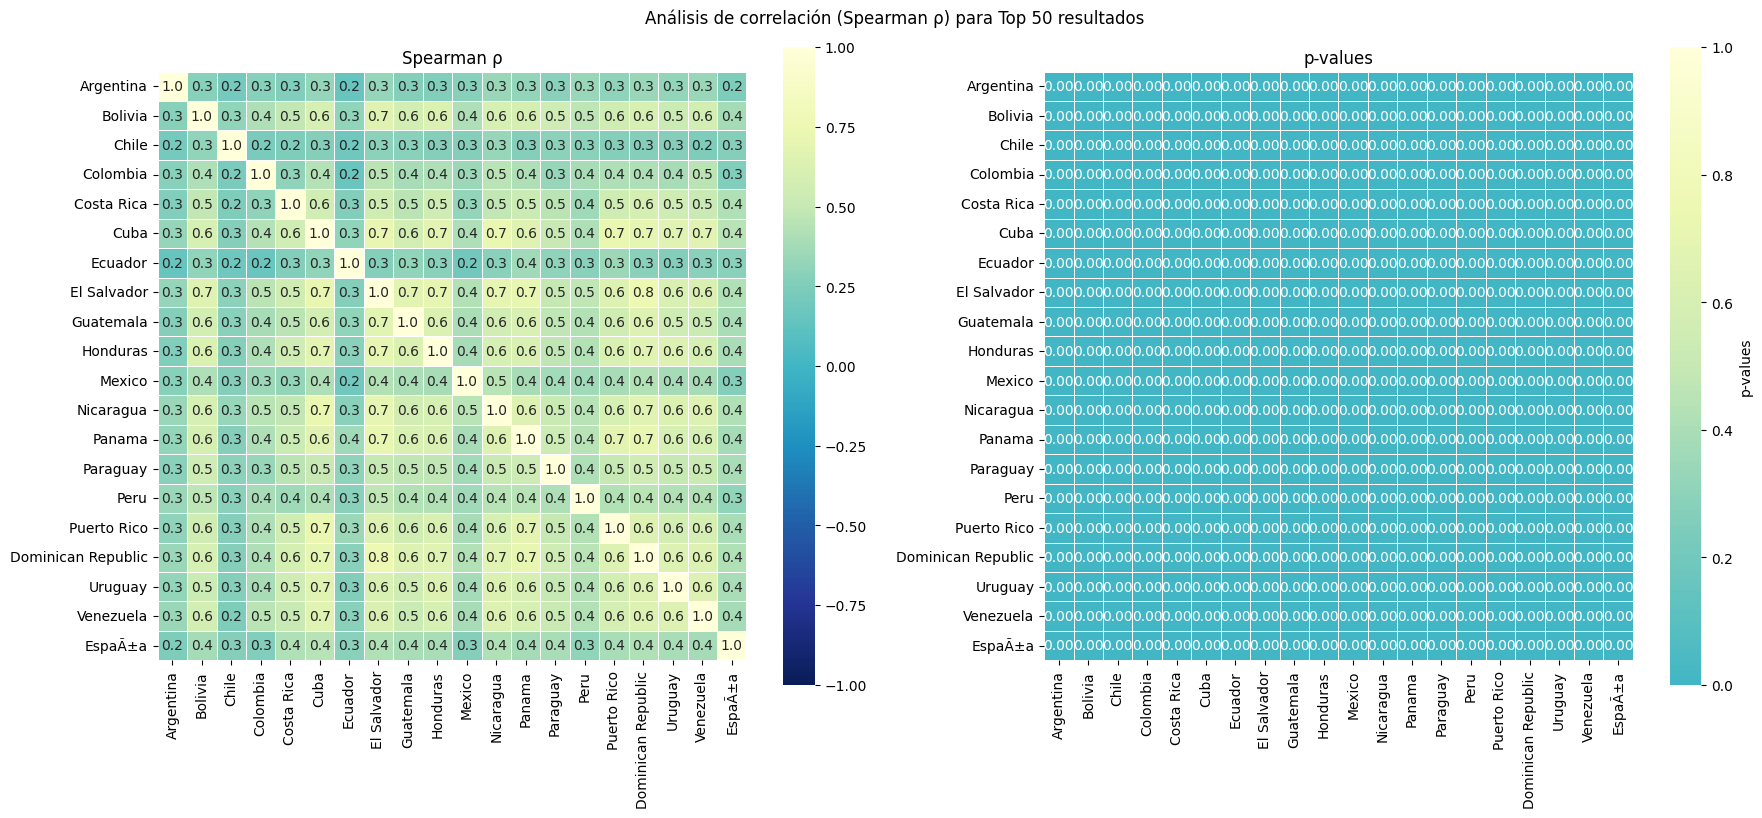

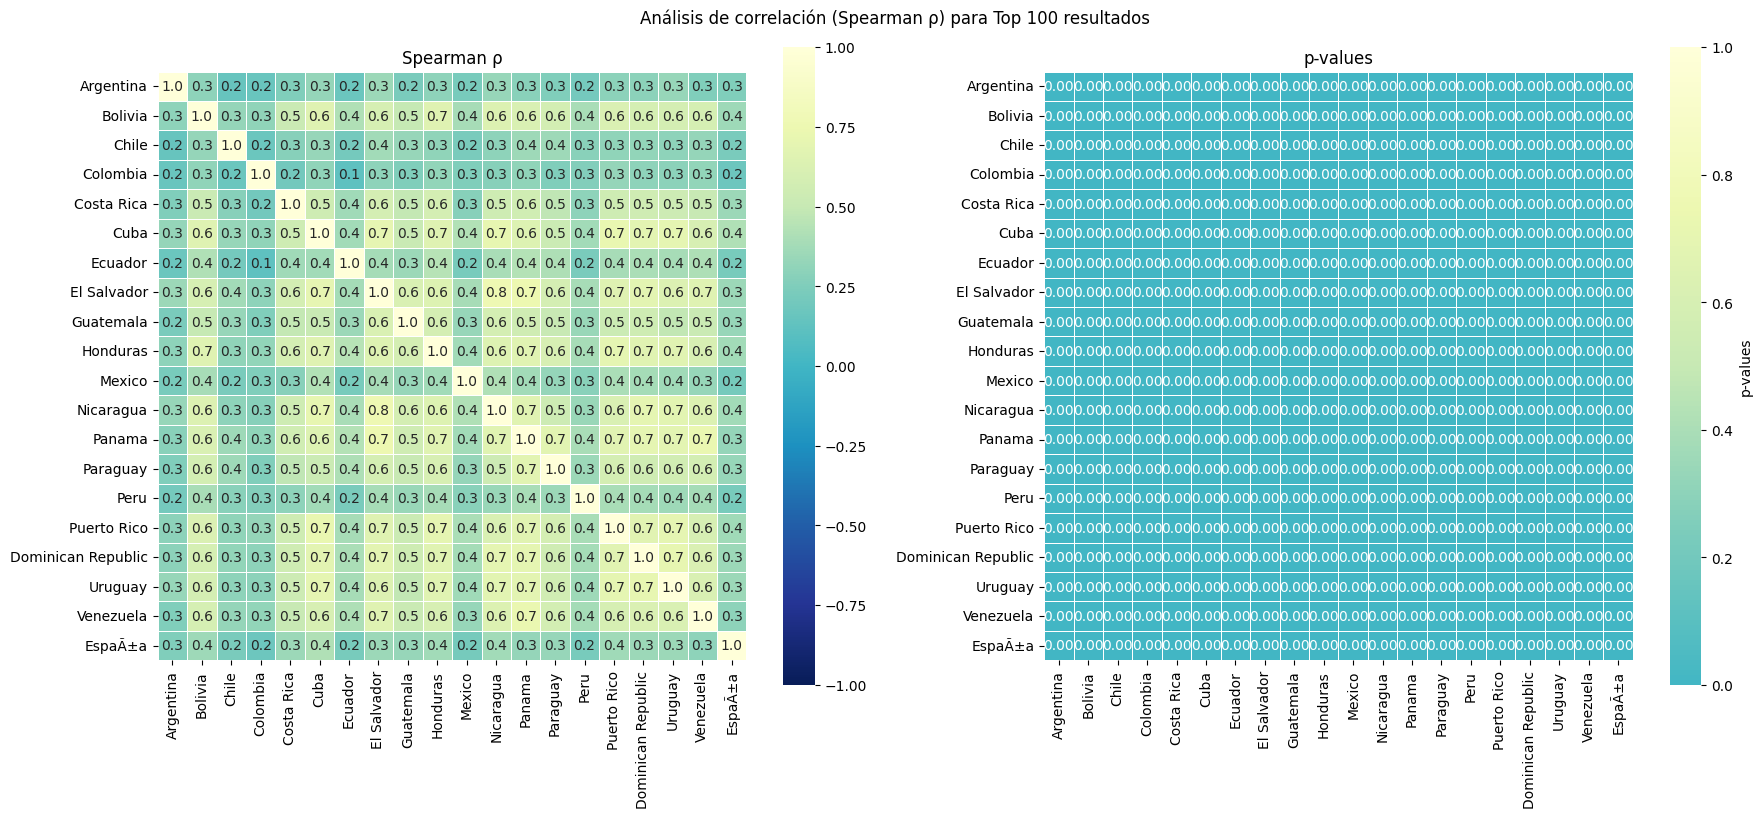

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

method = "spearman"  # "spearman" o "kendall"

for top in [10, 20, 50, 100]:
    rho, p, _ = correlation_matrix(resultados, all_hrefs, top, method=method, absent_policy="1.5top")

    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    method_dict = {"spearman": "Spearman ρ", "kendall": "Kendall τ"}
    cbar_kws={"label": method_dict[method]}

    # Heatmap method
    sns.heatmap(
        rho, annot=True, cmap="YlGnBu_r", center=0,
        fmt=".1f", vmin=-1, vmax=1, linewidths=0.5, square=True,
        **cbar_kws, ax=axes[0]
    )

    axes[0].set_title(method_dict[method])

    # Heatmap p-values
    sns.heatmap(
        p, annot=True, cmap="YlGnBu_r", center=0,
        fmt=".2f", vmin=0, vmax=1, linewidths=0.5, square=True,
        cbar_kws={"label": "p-values"}, ax=axes[1]
    )
    axes[1].set_title("p-values")

    plt.suptitle(f"Análisis de correlación ({method_dict[method]}) para Top {top} resultados")
    plt.tight_layout()
    plt.show()


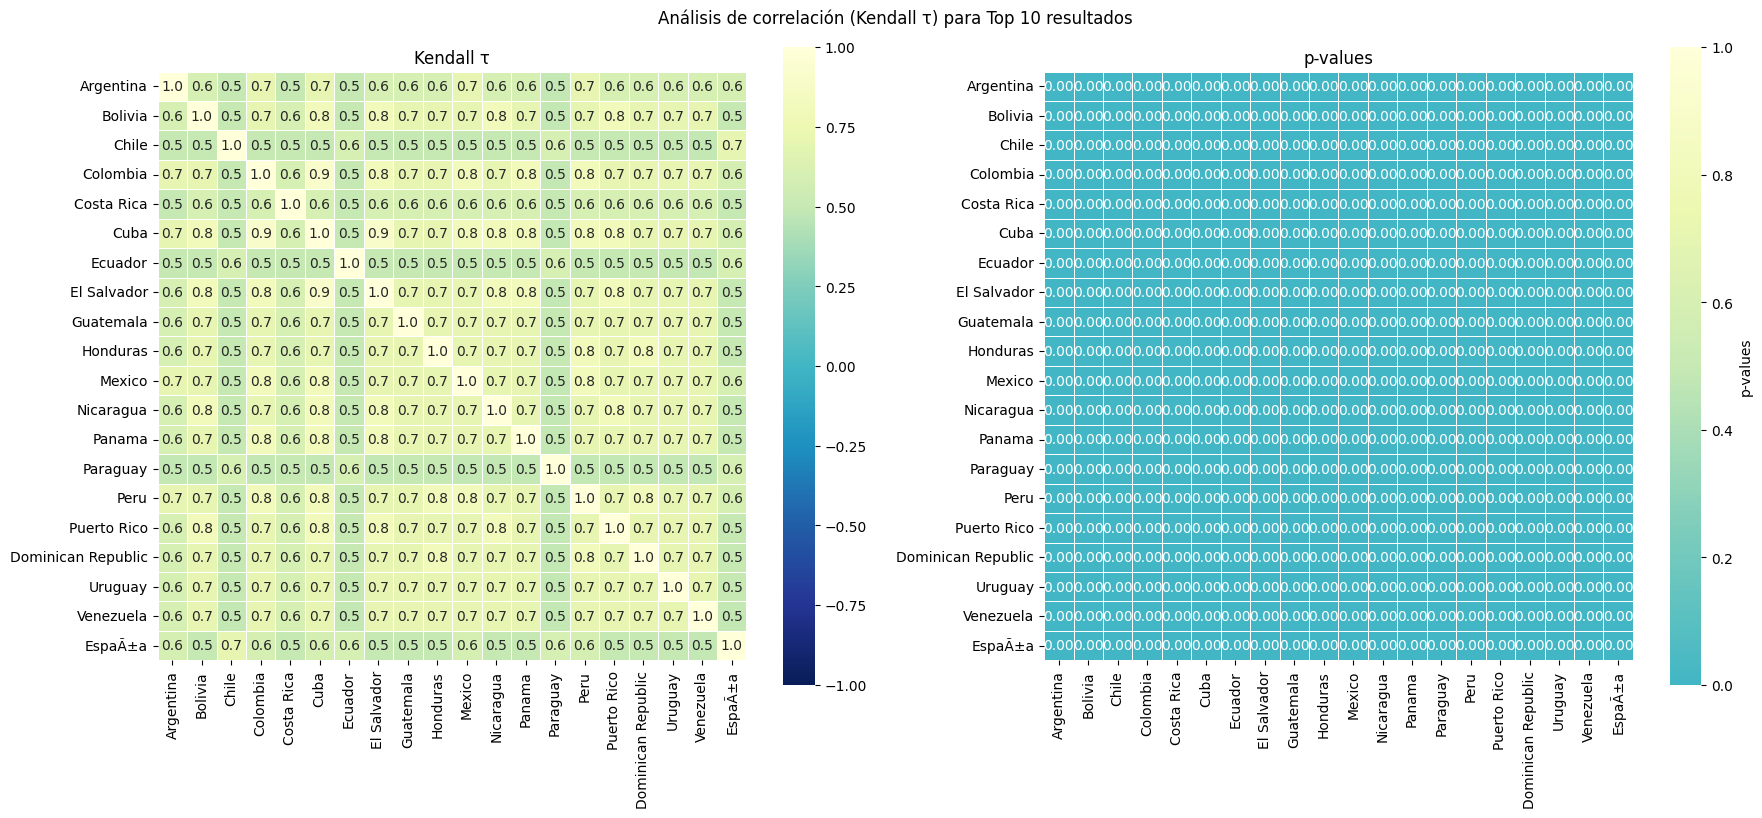

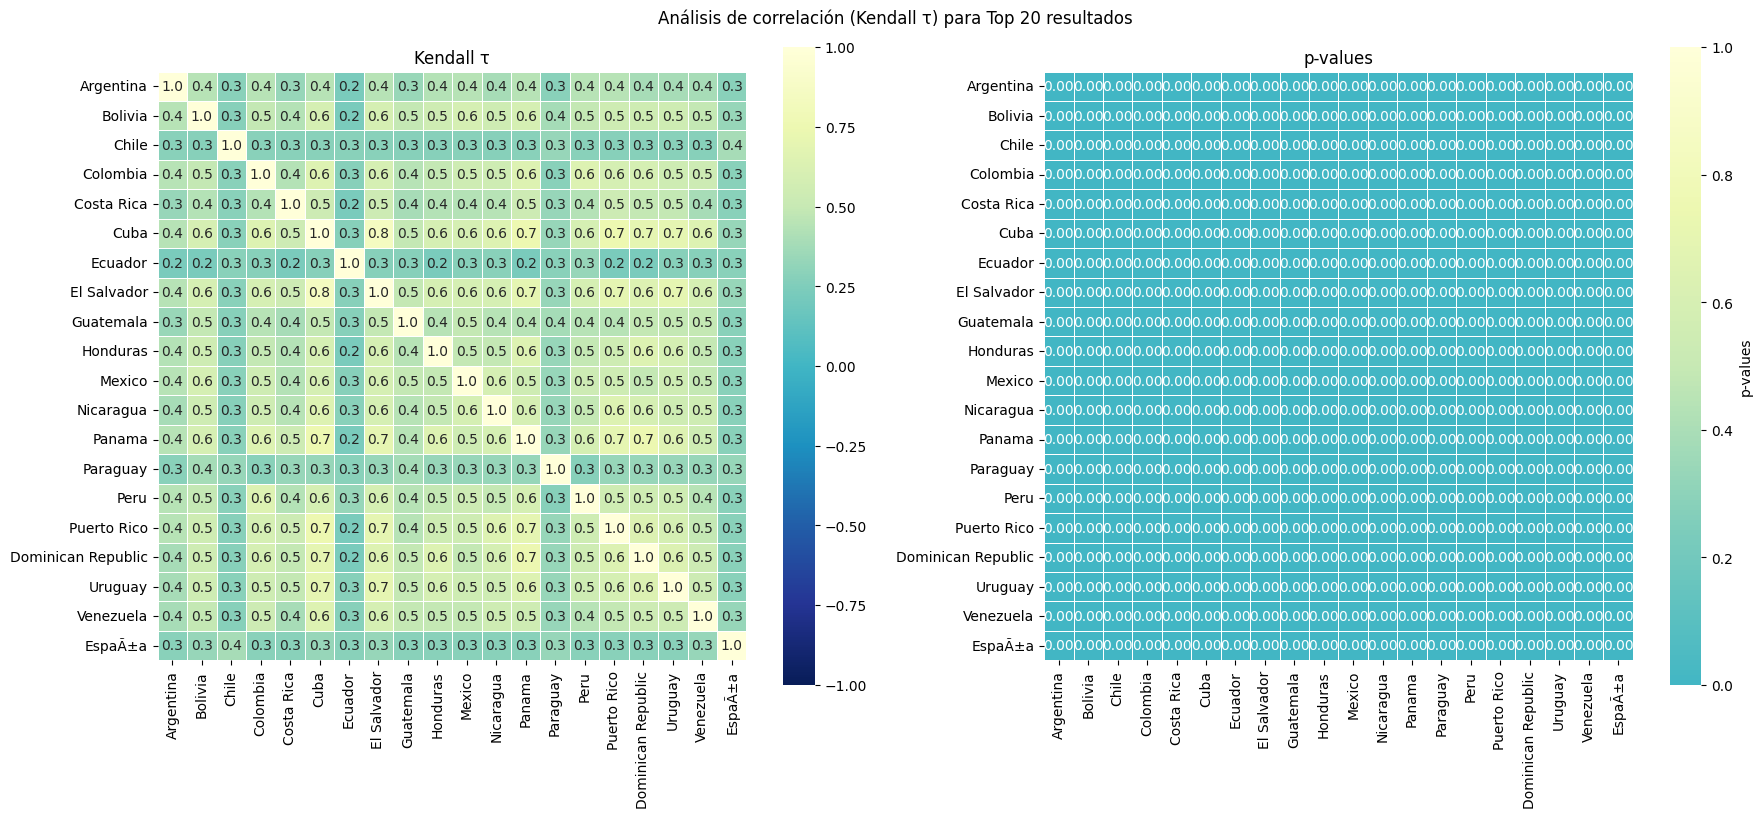

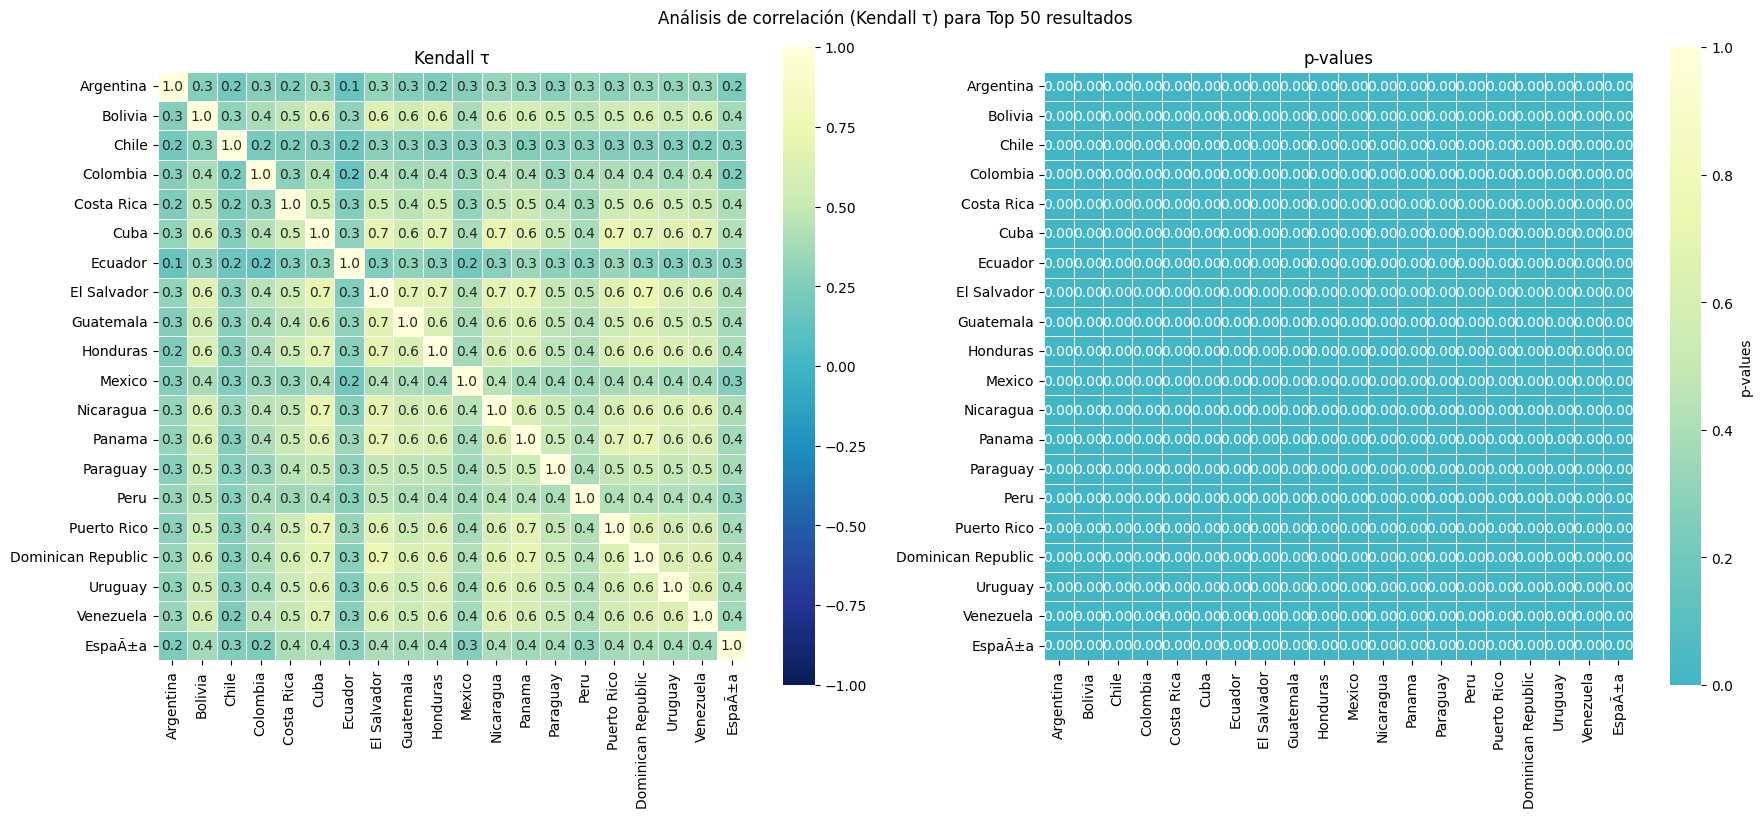

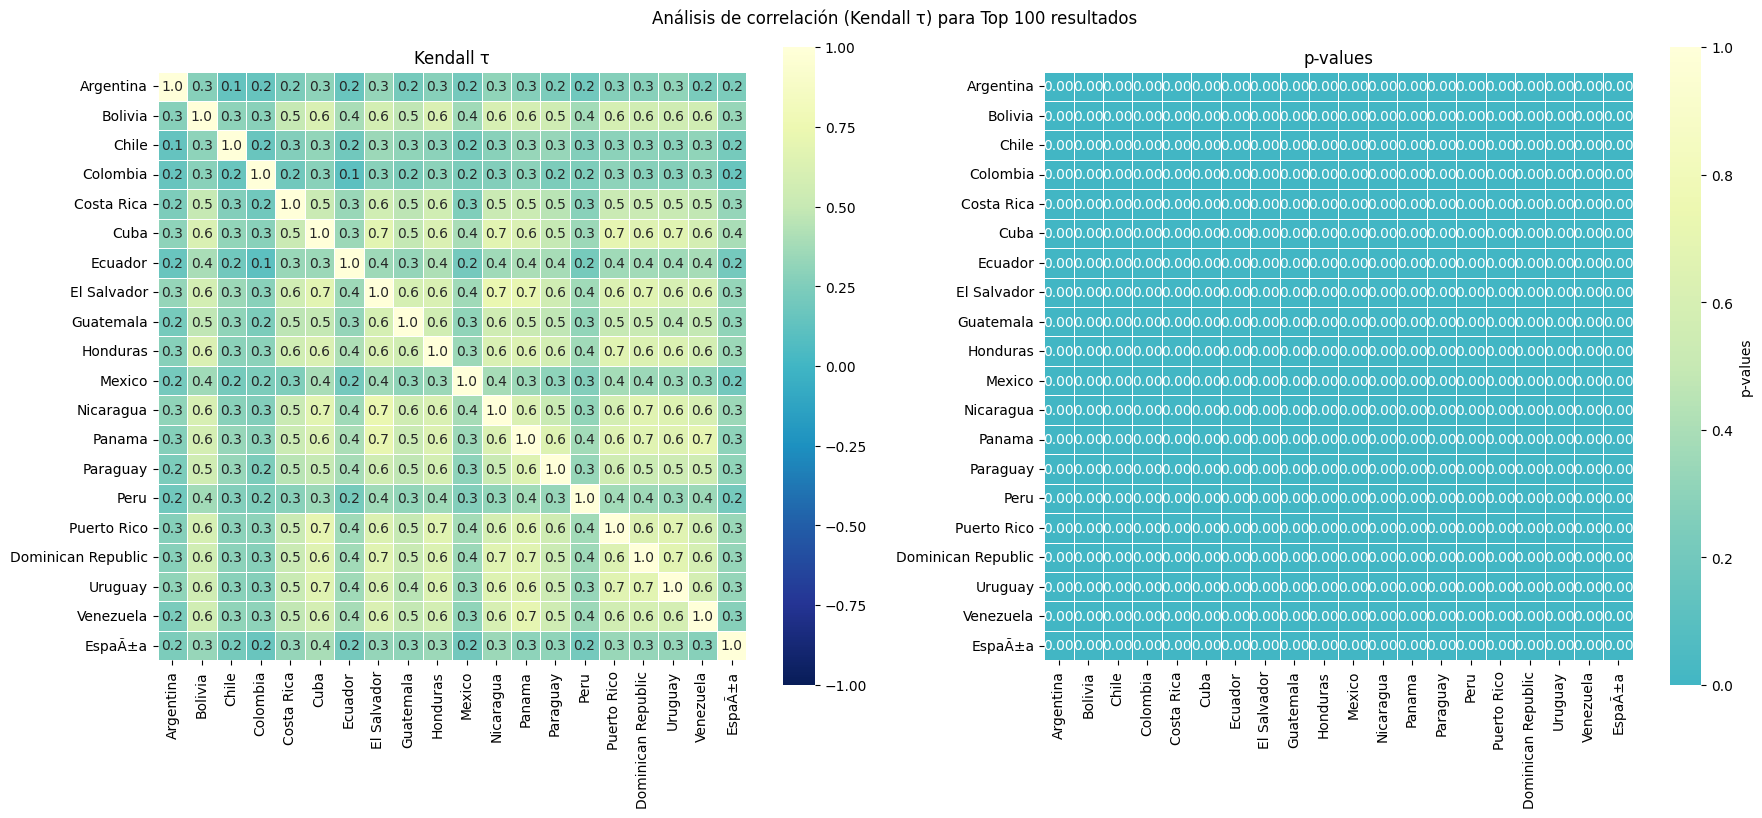

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

method = "kendall"  # "spearman" o "kendall"

for top in [10, 20, 50, 100]:
    rho, p, _ = correlation_matrix(resultados, all_hrefs, top, method=method, absent_policy="1.5top")

    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    method_dict = {"spearman": "Spearman ρ", "kendall": "Kendall τ"}
    cbar_kws={"label": method_dict[method]}

    # Heatmap method
    sns.heatmap(
        rho, annot=True, cmap="YlGnBu_r", center=0,
        fmt=".1f", vmin=-1, vmax=1, linewidths=0.5, square=True,
        **cbar_kws, ax=axes[0]
    )

    axes[0].set_title(method_dict[method])

    # Heatmap p-values
    sns.heatmap(
        p, annot=True, cmap="YlGnBu_r", center=0,
        fmt=".2f", vmin=0, vmax=1, linewidths=0.5, square=True,
        cbar_kws={"label": "p-values"}, ax=axes[1]
    )
    axes[1].set_title("p-values")

    plt.suptitle(f"Análisis de correlación ({method_dict[method]}) para Top {top} resultados")
    plt.tight_layout()
    plt.show()


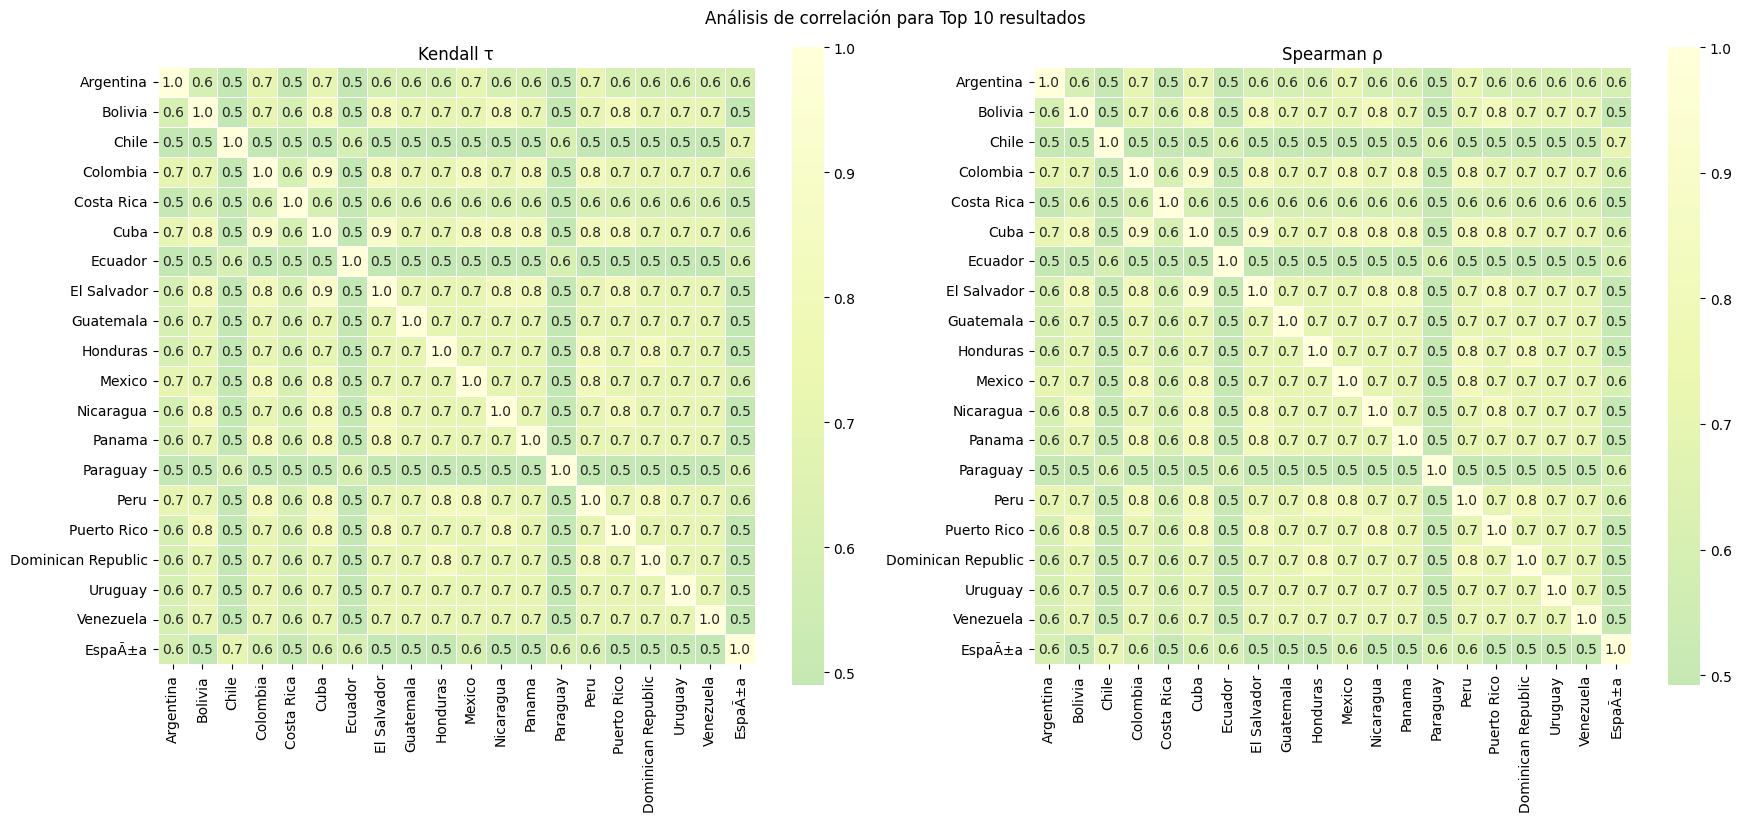

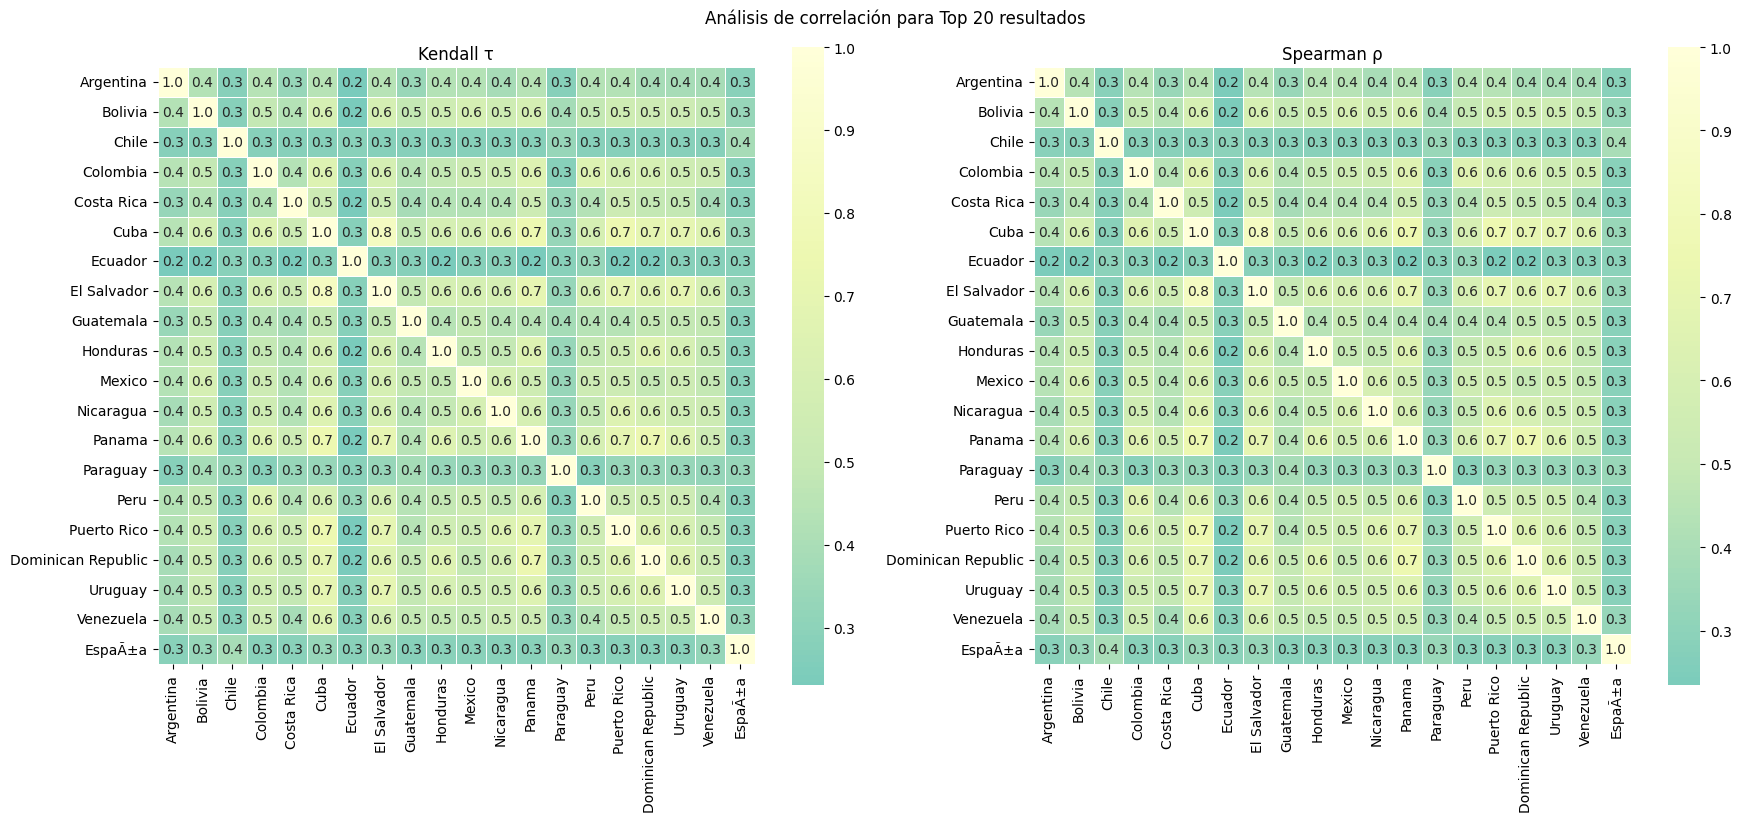

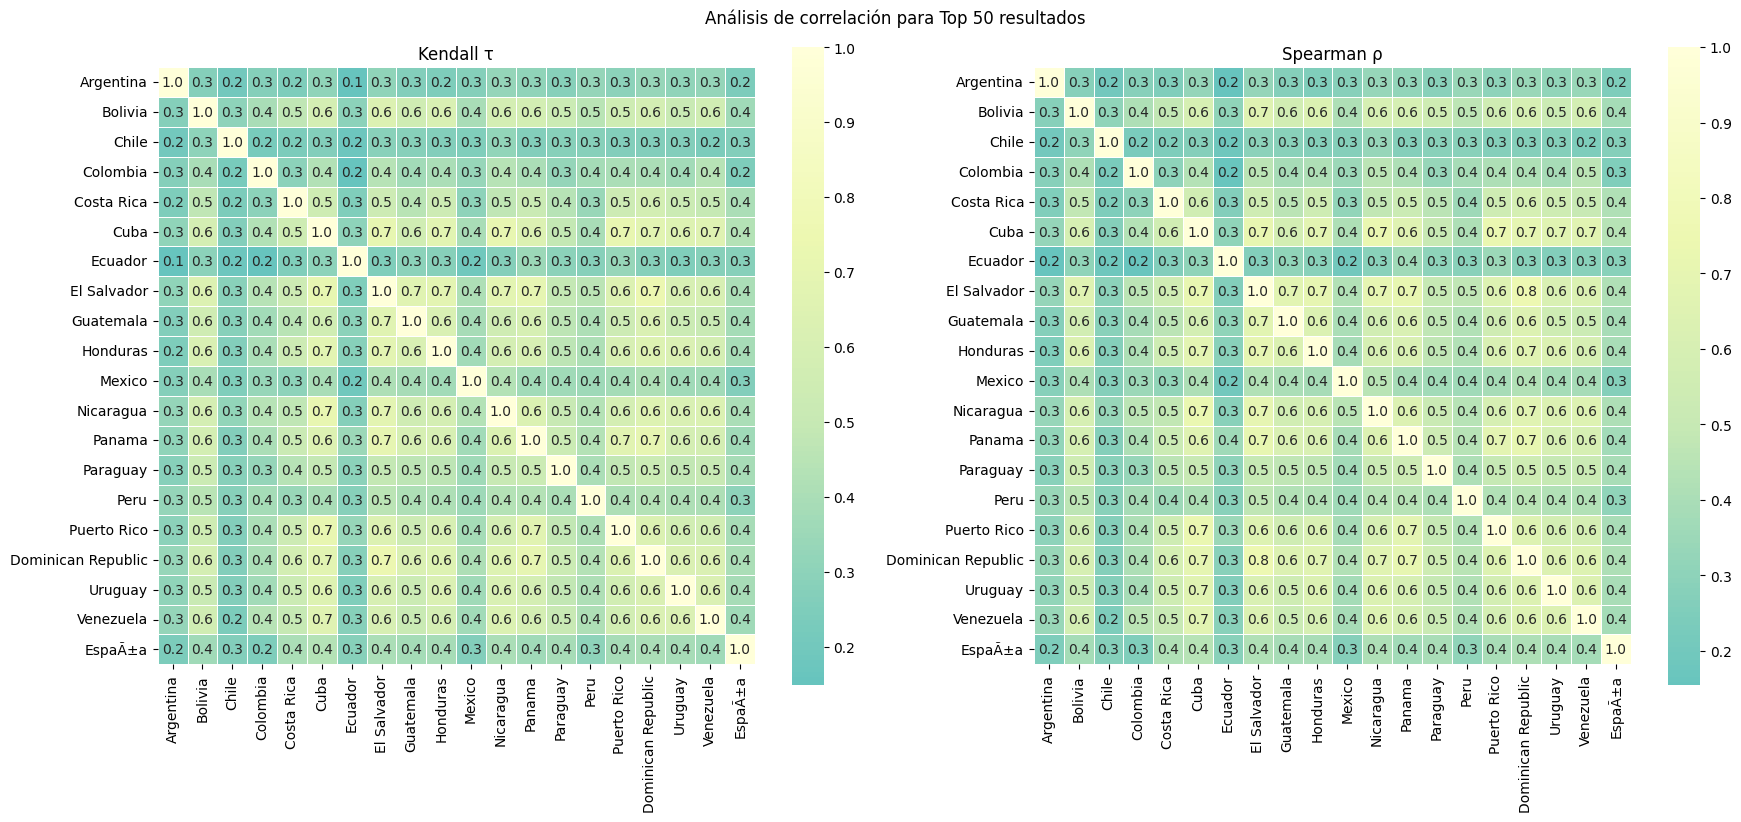

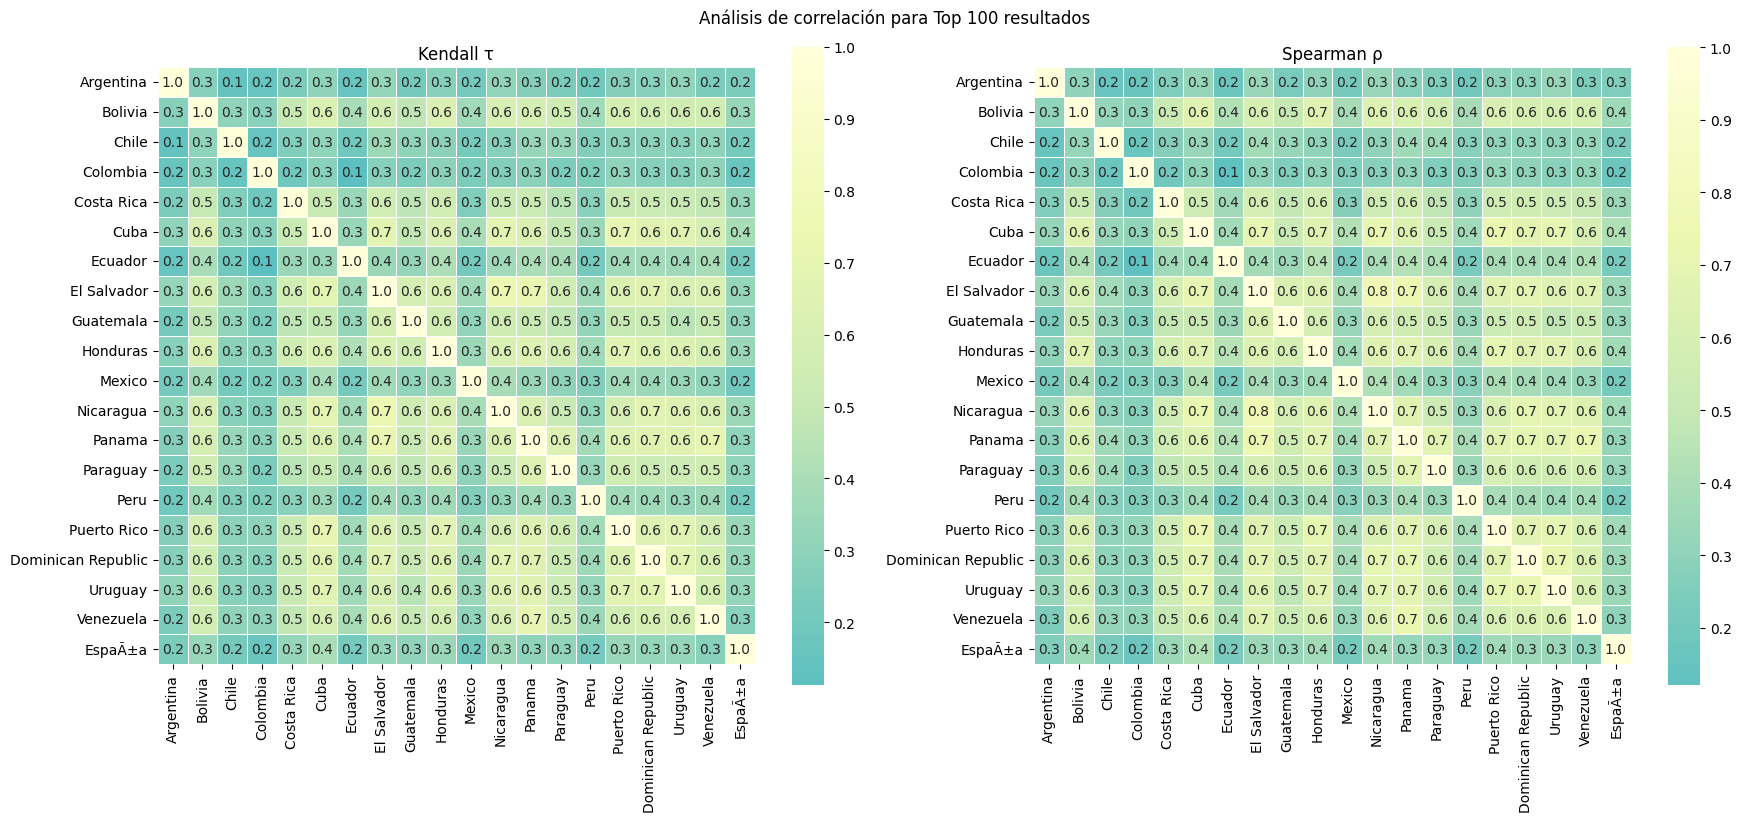

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

method_dict = {"spearman": "Spearman ρ", "kendall": "Kendall τ"}
cbar_kws={"label": method_dict[method]}

for top in [10, 20, 50, 100]:
    rho, _, _ = correlation_matrix(resultados, all_hrefs, top, method="spearman", absent_policy="1.5top")
    tau, _, _ = correlation_matrix(resultados, all_hrefs, top, method="kendall", absent_policy="1.5top")
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    sns.heatmap(
        tau, annot=True, cmap="YlGnBu_r", center=0,
        fmt=".1f", linewidths=0.5, square=True,
        **cbar_kws, ax=axes[0]
    )
    axes[0].set_title(method_dict['kendall'])

    sns.heatmap(
        rho, annot=True, cmap="YlGnBu_r", center=0,
        fmt=".1f", linewidths=0.5, square=True,
        **cbar_kws, ax=axes[1]
    )

    axes[1].set_title(method_dict['spearman'])

    plt.suptitle(f"Análisis de correlación para Top {top} resultados")
    plt.tight_layout()
    plt.show()


# Kendall W

In [20]:
from itertools import groupby
from math import isfinite
from scipy.stats import chi2
import numpy as np

In [ ]:
def kendalls_w_from_matrix(R):
    R = np.asarray(R, dtype=float)
    if R.ndim != 2:
        raise ValueError("R must be a 2D array (m x n).")
    m, n = R.shape

    Rj = R.sum(axis=0)
    Rbar = m * (n + 1) / 2.0
    S = np.sum((Rj - Rbar) ** 2)

    # Tie correction across each judge (row)
    tie_correction = 0.0
    for j in range(m):
        vals, counts = np.unique(R[j, :], return_counts=True)
        tie_correction += np.sum(counts**3 - counts)

    denom = (m**2) * (n**3 - n) - m * tie_correction
    if denom <= 0:
        return {"W": 0.0, "chi2": 0.0, "dof": n - 1, "p_value": 1.0,
                "S": float(S), "denominator": float(denom), "tie_correction": float(tie_correction)}

    W = 12.0 * S / denom
    chi2_stat = m * (n - 1) * W
    dof = n - 1
    from scipy.stats import chi2
    p_value = chi2.sf(chi2_stat, dof)

    return {"W": float(W), "chi2": float(chi2_stat), "dof": int(dof), "p_value": float(p_value),
            "S": float(S), "denominator": float(denom), "tie_correction": float(tie_correction)}

def kendalls_w_on_rankings(rankings_dict, absent_policy="max_plus_one", top=None):
    judges = list(rankings_dict.keys())
    universe = sorted(set().union(*rankings_dict.values()))
    ranks = []
    for j in judges:
        ordered = [{"href": h} for h in rankings_dict[j][: (top or len(rankings_dict[j]))]]
        ranks.append(build_aligned_ranks(ordered, universe, top or len(universe), absent_policy=absent_policy))
    R = np.vstack(ranks)
    res = kendalls_w_from_matrix(R)
    return res, R, judges, universe

# Example
rankings_example = {
    "Argentina": ["a.com", "b.com", "c.com", "d.com"],
    "Mexico":    ["b.com", "a.com", "e.com", "c.com"],
    "Spain":     ["a.com", "c.com", "f.com", "g.com"],
    "Chile":     ["h.com", "a.com", "c.com", "b.com"]
}

res, R, judges, universe = kendalls_w_on_rankings(rankings_example, absent_policy="max_plus_one", top=None)

